/Users/chewchiashaoyuan/Documents/Software/pypolycontain/pypolycontain/conversions.py:19: UserWarning: WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.
  warnings.warn("WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.")
/Users/chewchiashaoyuan/Documents/Software/pypolycontain/pypolycontain/containment.py:16: UserWarning: You don't have CDD package installed. Unable to run cone ray generation.
  warnings.warn("You don't have CDD package installed. Unable to run cone ray generation.")
100%|██████████| 2/2 [00:00<00:00, 6870.28it/s]


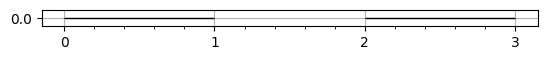

In [1]:
from large_gcs.geometry.polyhedron import Polyhedron
import numpy as np

from large_gcs.graph.cost_constraint_factory import (
    create_2d_x_equality_edge_constraint,
    create_2d_y_equality_edge_constraint,
    create_l1norm_edge_cost,
)
from large_gcs.graph.graph import DefaultGraphCostsConstraints, Edge, Graph
from large_gcs.algorithms.search_algorithm import SearchNode
from large_gcs.domination_checkers.ah_containment_domination_checker import (
    AHContainmentDominationChecker,
)

def create_simple_1d_graph() -> Graph:
    dim = 1
    # Convex sets
    sets = (
        # s
        Polyhedron.from_vertices([[0], [1]]),
        # t
        Polyhedron.from_vertices([[2], [3]]),
    )

    # Vertex names
    vertex_names = ["s", "t"]
    vertex_names += [f"p{i}" for i in range(len(sets) - 2)]

    # Edge costs
    # edge_cost = create_l2norm_squared_edge_cost(dim)
    edge_cost = create_l1norm_edge_cost(dim)
    default_costs_constraints = DefaultGraphCostsConstraints(edge_costs=[edge_cost])
    # Add convex sets to graph
    G = Graph(default_costs_constraints)
    G.add_vertices_from_sets(sets, names=vertex_names)
    G.set_source("s")
    G.set_target("t")

    # Edges
    hor_edges = {
        "s": ("t",),
    }

    def add_edges(edges, constraints):
        for u, vs in edges.items():
            for v in vs:
                # print(f"Adding edge {u} -> {v}")
                G.add_edge(Edge(u, v, constraints=constraints))

    add_edges(hor_edges, None)
    return G



G = create_simple_1d_graph()
G.plot_sets()
# G.plot_edges()
# G.plot_set_labels()
import matplotlib.pyplot as plt

# Setting major and minor ticks
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(plt.MultipleLocator(1))  # Major ticks at every 1
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.2))  # Minor ticks at every 0.2
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
plt.grid()

In [2]:
domination_checker = AHContainmentDominationChecker(graph=G)

n = SearchNode.from_vertex_path(["s", "t"])
A_n, b_n = domination_checker.get_epigraph_matrices(n)

X.A(): [[ 1.  0.  0.]
 [-1.  0.  0.]
 [ 0.  1.  0.]
 [ 0. -1.  0.]
 [ 1. -1. -1.]
 [-1.  1. -1.]]
X.b(): [ 1. -0.  3. -2.  0.  0.]


In [6]:
G.vertices['t'].convex_set.set.A()

array([[ 1.],
       [-1.]])

In [4]:
A_n, b_n

(array([[ 1.,  0.,  0.,  0.],
        [-1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [ 1., -1., -1.,  0.],
        [-1.,  1., -1.,  0.],
        [ 0.,  0.,  1., -1.],
        [ 0.,  0.,  0.,  1.]]),
 array([ 1.e+00, -0.e+00,  3.e+00, -2.e+00,  0.e+00,  0.e+00,  0.e+00,
         1.e+04]))